/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Pearson Correlation: 0.60
P-value: 7.77e-19


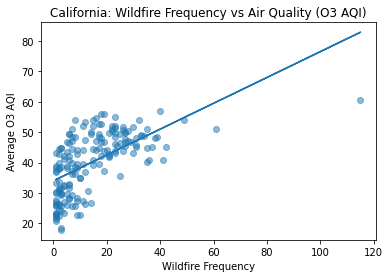

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

wildfire_data = pd.read_csv('FW_Veg_Rem_Combined.csv')
air_quality_data = pd.read_csv('pollution_2000_2023.csv')

# Convert dates
wildfire_data['disc_clean_date'] = pd.to_datetime(wildfire_data['disc_clean_date'], errors='coerce')
air_quality_data['Date'] = pd.to_datetime(air_quality_data['Date'], errors='coerce')

# Change state abbrev
state_abbrev_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire',
    'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina',
    'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania',
    'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee',
    'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}

wildfire_data['State'] = wildfire_data['state'].map(state_abbrev_to_name)

california_wildfires = wildfire_data[wildfire_data['State'] == 'California']
california_air_quality = air_quality_data[air_quality_data['State'] == 'California']
california_wildfires['YearMonth'] = california_wildfires['disc_clean_date'].dt.to_period('M')
wildfire_counts_ca = california_wildfires.groupby(['YearMonth']).size().reset_index(name='Wildfire_Frequency')

california_air_quality['YearMonth'] = california_air_quality['Date'].dt.to_period('M')
air_quality_aggregated_ca = california_air_quality.groupby(['YearMonth']).agg({'O3 AQI': 'mean'}).reset_index()
merged_data_ca = pd.merge(wildfire_counts_ca, air_quality_aggregated_ca, on='YearMonth', how='inner')


correlation, p_value = pearsonr(merged_data_ca['Wildfire_Frequency'], merged_data_ca['O3 AQI'])

print(f"Pearson Correlation: {correlation:.2f}")
print(f"P-value: {p_value:.2e}")


plt.scatter(merged_data_ca['Wildfire_Frequency'], merged_data_ca['O3 AQI'], alpha=0.5)
z = np.polyfit(merged_data_ca['Wildfire_Frequency'], merged_data_ca['O3 AQI'], 1)
p = np.poly1d(z)
plt.xlabel('Wildfire Frequency')
plt.ylabel('Average O3 AQI')
plt.title('California: Wildfire Frequency vs Air Quality (O3 AQI)')
plt.plot(merged_data_ca['Wildfire_Frequency'], p(merged_data_ca['Wildfire_Frequency']))
plt.show()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

R^2 Value: 0.2831


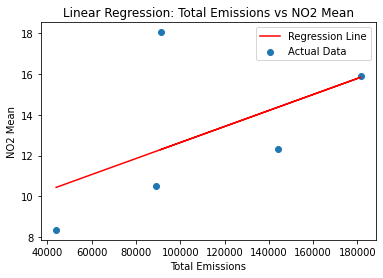

In [81]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

emissions_data = pd.read_csv('Emissions_Inventory.csv')
pollution_data = pd.read_csv('pollution_2000_2023.csv')

emissions_dc = emissions_data[
    (emissions_data['STATE'] == 'District of Columbia') &
    (emissions_data['POLLUTANT_TYPE'] == 'CAP')]
emissions_dc['Year'] = emissions_dc['DATASET_YEAR'].str.extract(r'(\d{4})').astype(int)
emissions_by_year = emissions_dc.groupby('Year')['EMISSIONS'].sum().reset_index()
emissions_by_year.rename(columns={'EMISSIONS': 'Total_Emissions'}, inplace=True)

pollution_dc = pollution_data[
    (pollution_data['State'] == 'District Of Columbia') &
    (pollution_data['County'] == 'District of Columbia')]
pollution_dc['Date'] = pd.to_datetime(pollution_dc['Date'])
pollution_dc['Year'] = pollution_dc['Date'].dt.year


pollution_by_year = pollution_dc.groupby('Year')[
    ['O3 Mean', 'NO2 Mean', 'SO2 Mean', 'CO AQI']
].mean().reset_index()

merged_data = pd.merge(emissions_by_year, pollution_by_year, on='Year', how='inner')

# Linear Regression
X = merged_data[['Total_Emissions']]
y = merged_data['NO2 Mean']
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"R^2 Value: {r2:.4f}")

plt.scatter(merged_data['Total_Emissions'], y, label='Actual Data')
plt.plot(merged_data['Total_Emissions'], y_pred, color='red', label='Regression Line')
plt.xlabel('Total Emissions')
plt.ylabel('NO2 Mean')
plt.title('Linear Regression: Total Emissions vs NO2 Mean')
plt.legend()
plt.show()


R-squared: 0.18


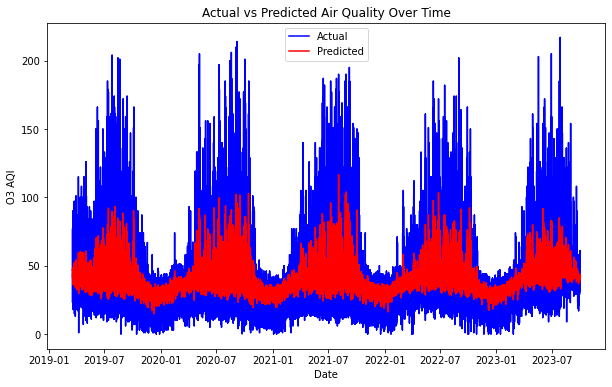

In [82]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

air_quality_data = pd.read_csv('pollution_2000_2023.csv')
air_quality_data['Date'] = pd.to_datetime(air_quality_data['Date'], errors='coerce')
air_quality_data = air_quality_data.sort_values(by='Date').dropna()

target_column = 'O3 AQI'
air_quality_data = air_quality_data[['Date', target_column]].dropna()

lag_days = 7  
for lag in range(1, lag_days + 1):
    air_quality_data[f'Lag_{lag}'] = air_quality_data[target_column].shift(lag)
air_quality_data = air_quality_data.dropna()

X = air_quality_data[[f'Lag_{lag}' for lag in range(1, lag_days + 1)]]
y = air_quality_data[target_column]
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(air_quality_data['Date'][split_index:], y_test, label='Actual', color='blue')
plt.plot(air_quality_data['Date'][split_index:], y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('O3 AQI')
plt.title('Actual vs Predicted Air Quality Over Time')
plt.legend()
plt.show()
